# Homework 4 (84 pts)

## Overview
This homework assignment is divided into two parts: regionalization and exploring how spatial regression can incorporate space into regression analysis. Although numerous variations of spatial regression are available in lecture examples and online resources, this assignment will only focus on the most commonly used models: slx, spatial error, and spatial lag models.

The primary objective of this assignment is to gain a deeper understanding of regionalization, spatial regression, and their practical application. By working with census data in NYC, you will gain insight into how spatially related areas can be clustered. Additionally, by analyzing Airbnb data in NYC, you will learn how spatial variables can impact regression outcomes and how to incorporate them into your analysis. 

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

In [2]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape
import cenpy
from sklearn.preprocessing import robust_scale

from pysal.explore import esda
from pysal.lib import weights

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

from pointpats import centrography

from pysal.model import spreg
import contextily

/var/folders/c5/dps3lj6n2sz8zkk_381lj9b1hnpv4f/T/ipykernel_3101/395037184.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/opt/anaconda3/envs/gds_py/lib/python3.9/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. 

## Regionalization
### 1. Retrieve and Clean Data (6 pts)
For the first section of this assignment, census data at the census tract level will be utilized. Similar to homework 2, you will retrieve census data using the 2015-2019 5-year estimate from the American Community Survey. Only NYC will be downloaded with the following variables: 'B19013_001E', 'B25077_001E', 'B15003_001E','B15003_022E', 'B02001_001E', 'B02001_002E', 'B25008_001E', 'B25008_003E', 'B11001_001E', 'B11001_006E', 'B25018_001E', 'B19083_001E',  'B01002_001E',  and 'B08012_001E'. The retrieved data will be stored in a dataframe named **acs_data**. (2 pts)

In [3]:
# insert your code here
acs_cp= cenpy.products.ACS()
acs_data = acs_cp.from_place('New York, NY', level='tract', variables=['B19013_001E', 'B25077_001E', 'B15003_001E','B15003_022E', 'B02001_001E', 'B02001_002E', 'B25008_001E', 'B25008_003E',
                                                                        'B11001_001E', 'B11001_006E', 'B25018_001E', 'B19083_001E',  'B01002_001E', 'B08012_001E'])

Matched: New York, NY to New York city within layer Incorporated Places


To generate new columns in acs_data, refer to [ACS Detailed Table Shells](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T). These new columns will include median household value, percentage of white, percentage of renters, percentage of female-led households, percentage of bachelor's degree holders, median number of rooms, Gini index, median age, and travel time to work. (2 pts)

In [4]:
# insert your code here
acs_data = acs_data.rename(columns={'B25077_001E':'med_house_value',
                                            'B25018_001E':'median_rooms',
                                            'B19083_001E':'gini_index',
                                            'B01002_001E':'median_age',
                                            'B08012_001E':'commute_time',})

#Percentage white
acs_data['perc_white'] = acs_data['B02001_002E']/acs_data['B02001_001E']

#Percentage of bachelor degree holders
acs_data['perc_bach_deg'] = acs_data['B15003_022E']/acs_data['B15003_001E']

#percentage rent
acs_data['perc_rent'] = acs_data['B25008_003E']/acs_data['B25008_001E']

#Percentage of female-led households
acs_data['perc_female_house'] = acs_data['B11001_006E']/acs_data['B11001_001E']

In [5]:
acs_data.head()

,GEOID,geometry,median_age,B02001_001E,B02001_002E,commute_time,B11001_001E,B11001_006E,B15003_001E,B15003_022E,...,B25008_003E,median_rooms,med_house_value,state,county,tract,perc_white,perc_bach_deg,perc_rent,perc_female_house
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",40.5,8498.0,8023.0,4042.0,3230.0,444.0,6256.0,1116.0,...,1114.0,6.0,461000.0,36,085,020801,0.944104,0.178389,0.131291,0.137461
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",43.6,4321.0,3882.0,1753.0,1681.0,165.0,3288.0,681.0,...,752.0,6.0,543500.0,36,085,017012,0.898403,0.207117,0.174034,0.098156
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",28.7,2816.0,1090.0,889.0,1051.0,290.0,1608.0,184.0,...,1497.0,3.8,288500.0,36,085,031901,0.387074,0.114428,0.531605,0.275928
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",28.1,5343.0,1756.0,1994.0,1641.0,625.0,3010.0,601.0,...,2528.0,5.2,328200.0,36,085,031902,0.328654,0.199668,0.474742,0.380865
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",41.5,5963.0,5683.0,3094.0,2313.0,226.0,4407.0,1071.0,...,387.0,5.7,420600.0,36,085,014606,0.953044,0.243022,0.064900,0.097709


In order to meet the requirements for later analysis, all nan values in acs_data should be replaced with 0. Following that, ONLY the above 9 variables should be rescaled using the `robust_scale()` function. The resulting scaled dataframe should be saved as **acs_scaled**. (2 pts)

In [6]:
# insert your code here
#replace nan with 0
acs_data = acs_data.fillna(0)

#scale the above 9 variables
cols = ['med_house_value', 'median_rooms', 'gini_index', 'median_age', 'commute_time', 'perc_white', 'perc_bach_deg', 'perc_rent', 'perc_female_house']
acs_scaled = gpd.GeoDataFrame(pd.DataFrame(robust_scale(acs_data[cols]), columns= cols), geometry = acs_data['geometry'], crs = 'EPSG:3857')

In [7]:
acs_scaled.head()

,med_house_value,median_rooms,gini_index,median_age,commute_time,perc_white,perc_bach_deg,perc_rent,perc_female_house,geometry
0,-0.280031,1.461538,-0.182287,0.440367,2.170452,1.063150,-0.092667,-1.132916,-0.087127,"POLYGON ((-8262278.990 4946228.710, -8261996.3..."
1,-0.064119,1.461538,-0.190312,0.819572,0.189920,0.978513,0.128476,-1.035026,-0.318026,"POLYGON ((-8257822.870 4945745.990, -8257700.4..."
2,-0.731484,-0.230769,2.054457,-1.003058,-0.557647,0.031549,-0.585025,-0.216126,0.726292,"POLYGON ((-8256173.450 4957701.750, -8256171.1..."
3,-0.627584,0.846154,1.222127,-1.076453,0.398443,-0.076642,0.071135,-0.346353,1.342746,"POLYGON ((-8256709.900 4959461.880, -8256698.5..."
4,-0.385763,1.230769,-0.872456,0.562691,1.350205,1.079705,0.404871,-1.284961,-0.320654,"POLYGON ((-8254594.160 4948740.120, -8254529.4..."


### 2. Analyze Data (2 pts)
Despite collecting all variables for each census tract, the underlying spatial characteristics are still uncertain. To confirm the applicability of regionalization to this dataset, it is necessary to determine whether spatial autocorrelation exists in these variables.

To do this, create a spatial weight matrix using the Queen method and calculate the global Moran's I for all 9 variables. Then, present your results in a dataframe that displays Moran's I and P-value for each variable. (2 pts)

In [8]:
# Set the seed for reproducibility
np.random.seed(1234)

In [9]:
# create spatial weight matrix
wq = weights.Queen.from_dataframe(acs_scaled)
wq.transform = "R"

('WARNING: ', 229, ' is an island (no neighbors)')


In [10]:
#create function to return  global Moran's I and p-value
def moran_by_col(y, w=wq):
    mo = esda.moran.Moran(y, w=w)
    mo_s = pd.Series(
        {"I": mo.I, "I-P value": mo.p_sim},
    )
    return mo_s


In [11]:
#present results
acs_scaled[cols].apply(moran_by_col, axis=0).T

,I,I-P value
med_house_value,0.525214,0.001
median_rooms,0.431719,0.001
gini_index,0.240902,0.001
median_age,0.241798,0.001
commute_time,0.348324,0.001
perc_white,0.769866,0.001
perc_bach_deg,0.596314,0.001
perc_rent,0.614226,0.001
perc_female_house,0.589929,0.001


### 3. Regionalization (6 pts)
Create the regionalization model based on **acs_scaled** by specifying the linkage as "ward" and the number of clusters as 5. (2 pts)

In [12]:
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=wq.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(acs_scaled[cols])

AgglomerativeClustering(connectivity=<2066x2066 sparse matrix of type '<class 'numpy.float64'>'
	with 12914 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

Using the results from your model, create a choropleth map of the 5 clusters. Remember to add a legend. (2 pts)

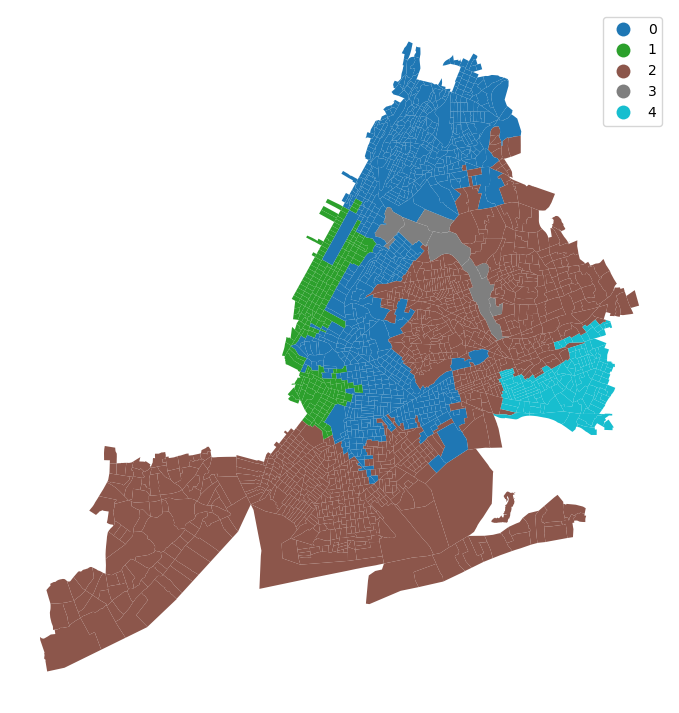

In [13]:
acs_scaled["ward5wq"] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
acs_scaled.plot(
    column="ward5wq",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

Regionalization results heavily rely on the spatial constraint, which is determined by the spatial weight matrix. To explore the impact of the spatial weight matrix on the results, try a new spatial matrix using 4 nearest neighbors.

Using ward linkage and 5 clusters specified in your function, generate a new regionalization model. Then, plot the new clusters with a legend. (2 pts)

In [14]:
# insert your code here
w4 = weights.KNN.from_dataframe(acs_scaled, k = 4)
w4.transform = "R"

model_kn = AgglomerativeClustering(
    linkage="ward", connectivity=w4.sparse, n_clusters=5
)
# Fit algorithm to the data
model_kn.fit(acs_scaled[cols])

AgglomerativeClustering(connectivity=<2066x2066 sparse matrix of type '<class 'numpy.float64'>'
	with 8264 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

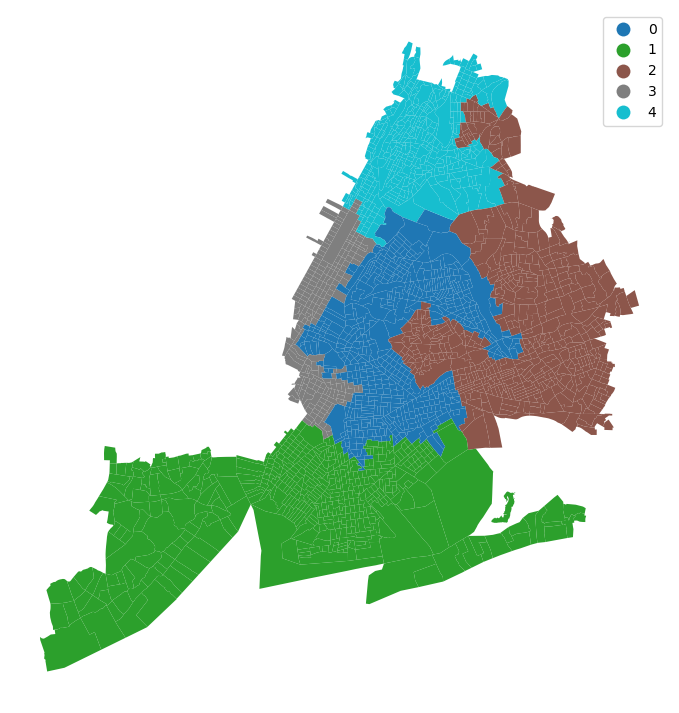

In [15]:
acs_scaled["ward5wknn"] = model_kn.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
acs_scaled.plot(
    column="ward5wknn",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### 4. Evaluate Regionalization Models (6 pts)
To determine which regionalization model is "better," you can compare your models based on measures of geographical coherence and goodness of fit.
### 4.1 Geographical Coherence (2 pts)
Compute the isoperimetric quotient for each cluster in both models. Then, concatenate the isoperimetric quotients into a new dataframe with columns labeled as *ward5wq* and *ward5wknn* and rows representing the 5 clusters. Show your dataframe. (2 pts)

In [16]:
# insert your code here
results = []
for cluster_type in ("ward5wq", "ward5wknn"):
    # compute the region polygons using a dissolve
    regions = acs_scaled[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)
# stack the series together along columns
pd.concat(results, axis=1)

,ward5wq,ward5wknn
0,0.046669,0.126724
1,0.064048,0.151508
2,0.053683,0.117768
3,0.155195,0.100872
4,0.190876,0.153410


### 4.2 Feature Coherence (goodness of fit) (4 pts)
Another measurement that can be used to evaluate the quality of the regionalization models is the `metrics.calinski_harabasz_score()` (CH) function, which calculates the ratio of within-cluster variance to between-cluster variance. Compute the CH score for both the original model with Queen spatial weight matrix and the model with 4 nearest neighbors. Then, report the CH scores of both models. (2 pts)

In [17]:
# insert your code here
ch_scores = []
for cluster_type in ("ward5wq", "ward5wknn"):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
        # using scaled variables
        acs_scaled[cols],
        # using these labels
        acs_scaled[cluster_type],
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display
pd.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
).set_index("cluster type")

,CH score
cluster type,
ward5wq,150.089355
ward5wknn,135.344478


Based on Geographical Coherence and Feature Coherence, which regionalization model performs better? And why? (2 pts)

The KNN model has better Geographical Coherence than the Queen model, as the knn-based regions are more compact than the queen-based regions. However, the the queen model has better Feature Coherence than the KNN model, as it has a higher CH score. This is a tradeoff between the two methods, as KNN creates more compact regions, but queen weights reduces variance.

## Spatial Regression
The second section uses Airbnb listing in Manhattan. Since you have been familiar with the datasets, codes are provided for retrieving data. 
### 1. Read Data

In [18]:
url_qr = "https://data.cityofnewyork.us/resource/63ge-mke6.json?$where=BoroName='Manhattan'"
ct = pd.read_json(url_qr)
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct, geometry='the_geom').set_crs(epsg = 4326)

In [19]:
listing_raw = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz')
listing_raw.price = listing_raw.price.replace('[\$,]', '', regex=True).astype(float)
listing_g = gpd.GeoDataFrame(listing_raw, 
                             geometry = gpd.points_from_xy(listing_raw.longitude, 
                                                           listing_raw.latitude)).set_crs(epsg = 4326)
listing = gpd.tools.sjoin(listing_g, ct[['geoid', 'boroname', 'the_geom']], predicate="within", how='inner')
listing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17333 entries, 0 to 34389
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            17333 non-null  int64   
 1   listing_url                                   17333 non-null  object  
 2   scrape_id                                     17333 non-null  int64   
 3   last_scraped                                  17333 non-null  object  
 4   source                                        17333 non-null  object  
 5   name                                          17325 non-null  object  
 6   description                                   17054 non-null  object  
 7   neighborhood_overview                         9538 non-null   object  
 8   picture_url                                   17333 non-null  object  
 9   host_id                                   

### 2. Clean and Visualize Data (24 pts)
### 2.1 Clean Data (8 pts)
Before proceeding with any regression analysis, it is always important to familiarize yourself with the data. One of the assumptions of Ordinary Least Squared (OLS) linear regression is that the underlying distribution of each variable should follow a normal distribution. One way to check for normality is by plotting the frequency of values in each variable using a histogram.

Make a histogram of *price* and answer whether it follows normal distribution in a separate markdown cell. (2 pts)

(array([1.7045e+04, 2.3400e+02, 3.6000e+01, 4.0000e+00, 0.0000e+00,
        1.2000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0.,  1975.,  3950.,  5925.,  7900.,  9875., 11850., 13825.,
        15800., 17775., 19750.]),
 <BarContainer object of 10 artists>)

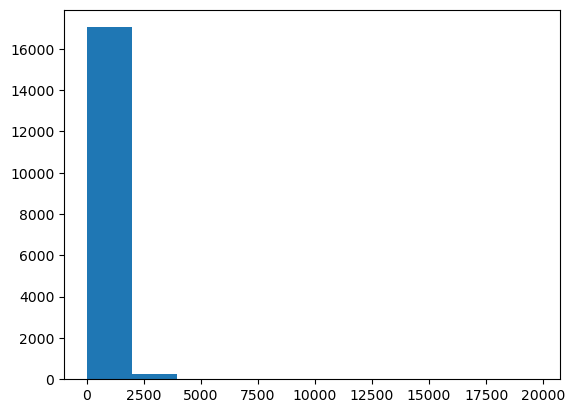

In [20]:
# insert your code here
plt.hist(listing['price'])

This series does not follow a normal distribution. It is highly right skewed, as there are a few highly-priced listings pulling the distribution towards the positive extremes. 

Notice that 0 may exist in *price* column, which makes no sense in real world because no Airbnb is offered for free. To confirm whether 0 exists, use `describe` function to check the numeric distribution of *price*. If yes, remove all rows with 0 in *price*. (2 pts)

In [21]:
listing['price'].describe()

count    17333.000000
mean       301.225062
std        533.570412
min          0.000000
25%        110.000000
50%        175.000000
75%        300.000000
max      19750.000000
Name: price, dtype: float64

In [22]:
# insert your code here
listing = listing[listing.price != 0]

For analytical purposes, it is common to transform highly skewed variables into data that appears to have a normal distribution. One commonly used transformation is to take the logarithm of the original variable.

Take the log value of *price* (named as *log_price*) and make a histogram plot of *log_price*. (2 pts). 

Does it look like a normal distribution? Answer in a separate markdown cell. (2 pts) 

In [23]:
# insert your code here
listing['log_price'] = np.log(listing['price'])

(array([4.000e+00, 3.510e+02, 2.836e+03, 7.151e+03, 4.590e+03, 1.554e+03,
        5.620e+02, 2.220e+02, 2.400e+01, 1.400e+01]),
 array([2.30258509, 3.06141746, 3.82024983, 4.5790822 , 5.33791456,
        6.09674693, 6.8555793 , 7.61441167, 8.37324403, 9.1320764 ,
        9.89090877]),
 <BarContainer object of 10 artists>)

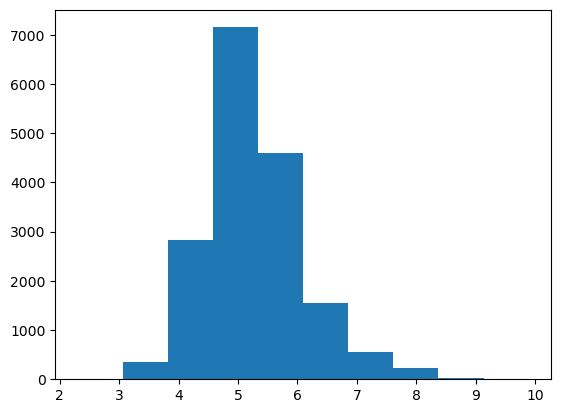

In [24]:
plt.hist(listing['log_price'])

The `log_price` column looks more like a normal distribution now.

### 2.2 Create Dummy Variables (12 pts)

Read [lecture example of San Diego Airbnb](https://geographicdata.science/book/notebooks/11_regression.html#exogenous-effects-the-slx-model) and you'll notice that both room type and property type can be important in determining listing prices. However, in order to include this information in a regression analysis, you need to transform these text variables into dummy variables.  

Following the same step in the example, you can create four dummy variables (rt_Entire_home/apt, rt_Hotel_room, rt_Private_room, and rt_Shared_room) for room type. Show your **rt** dataframe. (2 pts)

In [25]:
# insert your code here
rt = pd.get_dummies(listing['room_type'])

#Rename columns
rt = rt.rename(columns={'Entire home/apt':'rt_Entire_home/apt',
                        'Hotel room':'rt_Hotel_room',
                        'Private room':'rt_Private_room',
                        'Shared room':'rt_Shared_room'})
rt.head()

,rt_Entire_home/apt,rt_Hotel_room,rt_Private_room,rt_Shared_room
0,1,0,0,0
412,0,0,1,0
2696,0,0,1,0
3545,0,0,0,1
5390,1,0,0,0


Another variable that may be important in determining Airbnb listing prices is whether the host has been verified with their identity. Similarly, you can create a dummy variable to record this information. Since only t (standing for ture) and f (standing for false) are stored in *host_id_verified*, you can only rename t as the new *host_id_verified* in dataframe **host**. Show your dataframe **host**. (2 pts)

In [26]:
# insert your code here
#Dont need an f column since all info is stored in t
host = pd.get_dummies(listing['host_identity_verified'], drop_first=True)
host = host.rename(columns={'t':'host_id_verified'})
host.head()

,host_id_verified
0,1
412,1
2696,1
3545,0
5390,1


Though [the San Diego example](https://geographicdata.science/book/notebooks/11_regression.html#exogenous-effects-the-slx-model) provides a method to create dummy variables for property type, the code cannot be directly used in the New York City Airbnb dataset because the property type texts are recorded differently. With the modified *simplify* function, create a new column named *property_group* in **listing** dataframe. Next you can create dummy variables in dataframe **pg**. Show your dataframe **pg**. (2 pts) 

In [27]:
def simplify(p):
    bigs = ['apartment', 'condo', 'townhouse', 'resort']
    p_lst = p.split()
    for p in p_lst:
        if p in bigs:
            return p

# insert your code here
listing['property_group'] = [simplify(p) for p in listing['property_type']]

In [28]:
pg = pd.get_dummies(listing['property_group'], prefix='pg')

Another important variable that affects listing prices is the number of bathrooms in each listing, which is stored as text in the **listing** dataframe with null values. To prepare the data for analysis, replace all null values in the *bathrooms_text* column with 0. 

Next, you can create a function called *find_bath* like *simplify*. *find_bath* function will split the text in *bathrooms_text* and return the number of bathrooms in float. (2 pts) 

Apply this function to *bathrooms_text* to create a new column *bathrooms* in **listing**. (2 pts)

In [29]:
#replace na values with 0
listing['bathrooms_text'] = listing['bathrooms_text'].fillna(0)
#Look at unique values
listing['bathrooms_text'].unique()

array(['1 bath', '1 private bath', '1 shared bath', '2 shared baths',
       '2 baths', '1.5 baths', '3 baths', '1.5 shared baths',
       '0 shared baths', '2.5 baths', '3 shared baths', '4 baths',
       '3.5 baths', '5.5 baths', '4.5 baths', 'Half-bath',
       '2.5 shared baths', '0 baths', 0, 'Shared half-bath',
       'Private half-bath', '5 baths', '6.5 baths', '6 baths',
       '4.5 shared baths', '6 shared baths', '4 shared baths', '8 baths',
       '7 baths', '3.5 shared baths'], dtype=object)

Looks like the number of baths is always the first value, unless its a half-bath, which needs to be returned as 0.5.

In [30]:
#create function to return number of bathrooms as float
def find_bath(p):
    #store half-bath text to detect half-baths
    half_baths = ['half-bath', 'Half-bath']
    try:
        p_lst = p.split()
        try:
        #number baths is the first value for the most part
            return float(p_lst[0])
        except:
        #If value is just a half-bath, return 0.5
            for p in p_lst:
                if p in half_baths:
                    return 0.5
    #Cant split the null values replaced as zero, so just return 0 for these
    except:
        return 0.0
  

In [31]:
listing['bathrooms'] = [find_bath(p) for p in listing['bathrooms_text']]

Merge dataframe **rt**, **host**, and **pg** to **listing**. Show the infomation of your new **listing**. (2 pts)

In [32]:
# insert your code here
listing = pd.concat([listing, rt, host, pg], axis = 1)

In [33]:
listing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17308 entries, 0 to 34389
Data columns (total 90 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            17308 non-null  int64   
 1   listing_url                                   17308 non-null  object  
 2   scrape_id                                     17308 non-null  int64   
 3   last_scraped                                  17308 non-null  object  
 4   source                                        17308 non-null  object  
 5   name                                          17300 non-null  object  
 6   description                                   17054 non-null  object  
 7   neighborhood_overview                         9538 non-null   object  
 8   picture_url                                   17308 non-null  object  
 9   host_id                                   

### 2.3 Create Spatial Variable (Distance to City Center) (4 pts)
Given the spatial nature of NYC listing, adding spatial variable can help improve the regression performance. One tpical spatial variable is the distance to city center. Though there is no concensus on where exactly the city center is in NYC, you can use the median center as a proxy. Recall what you've done in Homework 2 to create the median center and name it as *city_center*. (2 pts) 

In [34]:
# insert your code here
city_center = centrography.euclidean_median(listing[["longitude", "latitude"]])

To calculate distance in meters from coordinates, you must first transform the crs into the USA Contiguous Albers Equal Area (provided below) because this datum is measured by meters. Refer to [data cleaning process for San Diego Airbnb](https://geographicdata.science/book/data/airbnb/regression_cleaning.html) and generate *d2center* column in **listing**. (2 pts)

In [35]:
tgt_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 "\
          "+lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"


In [36]:
from shapely import Point
from scipy.spatial.distance import cdist

center = gpd.GeoSeries(Point(city_center[0], city_center[1]), crs=listing.crs).to_crs(tgt_crs)[0]
center = (center.x, center.y)

d2b = lambda pt: cdist([(pt.x, pt.y)], [center])[0][0]/1000
# insert your code here
listing['d2center'] = listing['geometry'].to_crs(tgt_crs)\
                                 .apply(d2b)

## 3. Regressions (40 pts)
### 3.1 Linear Regression (6 pts)
The independent variables used here include "accommodates", "bedrooms", "bathrooms", "host_id_verified", "rt_Shared_room", "pg_apartment", "pg_condo", "pg_townhouse", "pg_resort", "d2center" and the dependent variable is "log_price". Create a new dataframe **X** which contains all independent variables and *geometry* in **listing**. Remove all null values in **X** and show the shape of **X**. (2 pts)

In [37]:
# insert your code here
variables = ['accommodates', 'bedrooms', 'host_id_verified', 'rt_Shared_room', 'pg_apartment', 'pg_condo', 'pg_townhouse', 'pg_resort', 'd2center', 'geometry']

X = listing[variables].dropna()
X.shape

(14752, 10)

Create another series **y** storing *log_price*. Remember to keep **X** and **y** in the same number of rows. Show the number of rows of **y**. (2 pts)

In [38]:
# insert your code here
y = listing['log_price'].loc[X.index]
y.shape

(14752,)

Run OLS based on your **X** and **y**. Interpret your results: Do these variables explain the listing price well? Why or why not? (2 pts)

In [39]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y.values,
    # Independent variables
    X.drop(['geometry'], axis = 1).values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variables[0:9],
)

In [40]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       14752
Mean dependent var  :      5.2698                Number of Variables   :          10
S.D. dependent var  :      0.8565                Degrees of Freedom    :       14742
R-squared           :      0.4814
Adjusted R-squared  :      0.4811
Sum squared residual:    5611.708                F-statistic           :   1520.4310
Sigma-square        :       0.381                Prob(F-statistic)     :           0
S.E. of regression  :       0.617                Log likelihood        :  -13803.104
Sigma-square ML     :       0.380                Akaike info criterion :   27626.208
S.E of regression ML:      0.6168                Schwarz criterion     :   27702.199

-----------------------------------------------------------------------------

In [41]:
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m1.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m1.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m1.t_stat],
    },
    index=m1.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(variables[0:9]).round(4)

,Coeff.,Std. Error,P-Value
accommodates,0.1999,0.0035,0.0000
bedrooms,0.0860,0.0100,0.0000
host_id_verified,-0.0578,0.0144,0.0001
rt_Shared_room,-0.4060,0.0426,0.0000
pg_apartment,0.2984,0.0361,0.0000
pg_condo,0.2018,0.0200,0.0000
pg_townhouse,0.0649,0.0416,0.1189
pg_resort,0.2335,0.0983,0.0176
d2center,-0.1080,0.0019,0.0000


Based on the R-squared value above, we see that the variables in this OLS explains about 48% of the variance in the dependent variable, `log_price`. This is a decent fit, but it suggests that there is a lot of variance in the dependent variable still unexplained. The OLS model does not sufficiently describe the variance in the data. 

### 3.2 Verification (8 pts)
The above OLS model provides a base model for further analysis. From all perspectives, this model should be revised to better represent the reality. To verify whether space plays an important role in explaining listing price, the residuals of OLS can help.

Create a new column *residual* in dataframe **X**. Plot the residuals with 5 quantile using your color. Add legend and basemap to your map. (2 pts)

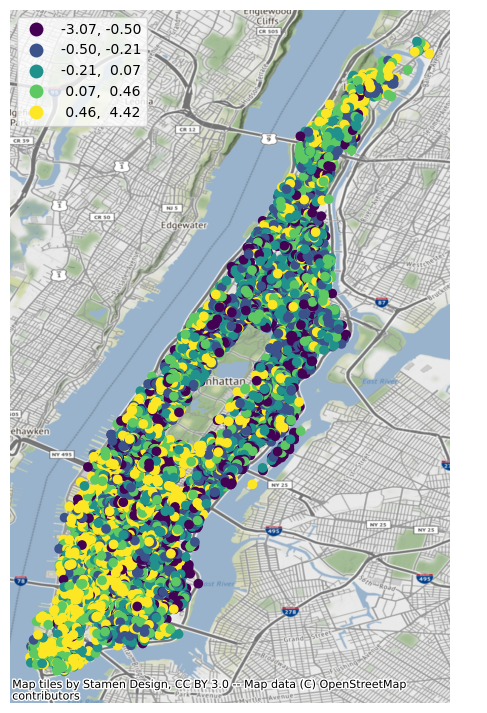

In [42]:
X['residuals'] = m1.u
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot residuals including a legend
X.plot(
    column="residuals",
    legend=True,
    scheme = 'Quantiles',
    k = 5,
    ax=ax,
)
# Add basemap
contextily.add_basemap(ax, crs=X.crs)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

How do you interpret the spatial distribution of your OLS residuals? Is it clustered or scattered across NYC? (2 pts)

There is some clustering in positive residulas in lower Manhattan as seen in yellow, but residuals in upper Manhattan are quite scattered. 

In addition to visual check, Moran's I provides more proof on spatial distribution. Create a row-standardized spatial weight matrix (named as wd) from distance-based knn method. Use 4 as the number of neighbors. (2 pts)

In [43]:
# insert your code here
wd = weights.KNN.from_dataframe(X, k=4)
#Row-standardize
wd.transform = "R"

Next, you can check the global Moran's I with the residual. What is the value? And how can you conclude the spatial characteristics of the residual? (2 pts)

In [44]:
# insert your code here
resid_moran = esda.moran.Moran(X['residuals'], w = wd)
resid_moran.I

0.26719534289808444

There is slight spatial clustering in the residuals based on the the Moran's I 

### 3.3 Exogenous Effect -- SLX Model (8 pts)
With spatial clustering exists in the OLS residuals, it implies that adding spatial components to your regression can improve the model performance. Assuming that there is no interaction between the dependent variables and their spatial lags, SLX model can be built using `spreg.OLS` function as the spatial lags of the dependent variables are treated as exogenous variables.

Create only spatial lags for dummy variables of property types condo, townhouse, and resort. Rename the spatial lags by adding "w_" before their original names. Store these new variables in dataframe **wx**. (2 pts)  

In [45]:
# insert your code here
dummy_var = ['pg_condo', 'pg_townhouse', 'pg_resort']
wx = X[dummy_var].apply(lambda y: weights.spatial_lag.lag_spatial(wd, y)
        # Rename the spatial lag, adding w_ to the original name
    )
wx = wx.rename(columns=lambda c: "w_"+ c)

Create a new dataframe **slx_exog** by merging **X** and **wx**. Now you can apply `spreg.OLS` function to the new dataframe and fit the model. Present your model results below. (2 pts)

In [46]:
# insert your code here
slx_exog = X.join(wx)

#Run model
m2 = spreg.OLS(
    # Dependent variable
    y.values,
    # Independent variables
    slx_exog.drop(['geometry', 'residuals'], axis = 1).values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variables[0:9] + list(slx_exog.columns[11:14]),
)

In [47]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       14752
Mean dependent var  :      5.2698                Number of Variables   :          13
S.D. dependent var  :      0.8565                Degrees of Freedom    :       14739
R-squared           :      0.4822
Adjusted R-squared  :      0.4817
Sum squared residual:    5603.367                F-statistic           :   1143.6165
Sigma-square        :       0.380                Prob(F-statistic)     :           0
S.E. of regression  :       0.617                Log likelihood        :  -13792.133
Sigma-square ML     :       0.380                Akaike info criterion :   27610.265
S.E of regression ML:      0.6163                Schwarz criterion     :   27709.054

-----------------------------------------------------------------------------

Compare the result with the OLS result. Is there any difference with the coefficients of each variable? Are there any new variables? Are these coefficients all statistically significant? (2 pts)

Does slx model improve the performance of OLS? (2 pts)

There is not much difference in coefficient values between OLS and slx; the values are nearly identical. The slx does include additional variables based on the spatial lags of the dummy variables calculated earlier. The slx model has a similar $R^{2}$ value to OLS, so it doesn't really improve performance compared to OLS.

In [48]:
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m2.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(variables[0:9] + list(slx_exog.columns[11:14])).round(4)

,Coeff.,Std. Error,P-Value
accommodates,0.2003,0.0035,0.0000
bedrooms,0.0852,0.0101,0.0000
host_id_verified,-0.0585,0.0143,0.0000
rt_Shared_room,-0.4034,0.0426,0.0000
pg_apartment,0.2977,0.0362,0.0000
pg_condo,0.2112,0.0202,0.0000
pg_townhouse,0.0819,0.0418,0.0502
pg_resort,0.2813,0.1115,0.0117
d2center,-0.1068,0.0019,0.0000
w_pg_condo,-0.1231,0.0373,0.0010


### 3.4 Spatial Error Regression (6 pts)
Another assumption is that spatial clustering exists only in the error terms of OLS model. Use the same dependent and independ variables and spatial weight matrix *wd* for your spatial error model. Report the model results below. (2 pts)

In [49]:
# insert your code here
m3 = spreg.GM_Error_Het(
    # Dependent variable
    y.values,
    # Independent variables
    X.drop(['geometry', 'residuals'], axis = 1).values,
    # Spatial weights matrix
    w=wd,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variables[0:9],
)

In [50]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       14752
Mean dependent var  :      5.2698                Number of Variables   :          10
S.D. dependent var  :      0.8565                Degrees of Freedom    :       14742
Pseudo R-squared    :      0.4797
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.9783477       0.0225452     220.8163833       0.0000000
        accommodates       0.1798626       0.0036989      48.6265701       0.00

In [51]:
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m3.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m3.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m3.z_stat],
    },
    index=m3.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(variables[0:9] + ["lambda"]).round(4)

,Coeff.,Std. Error,P-Value
accommodates,0.1799,0.0037,0.0000
bedrooms,0.1228,0.0110,0.0000
host_id_verified,-0.0158,0.0144,0.2718
rt_Shared_room,-0.3440,0.0503,0.0000
pg_apartment,0.1751,0.0378,0.0000
pg_condo,0.2186,0.0190,0.0000
pg_townhouse,0.1246,0.0408,0.0023
pg_resort,0.3248,0.1111,0.0035
d2center,-0.1089,0.0028,0.0000
lambda,0.4054,0.0089,0.0000


Compare the result with the OLS result. Is there any difference with the coefficients of each variable? Are these coefficients all statistically significant? (2 pts) 

What is the meaning of lambda? Does spatial error model improve the performance of OLS? (2 pts) 

There are differences in the coefficient values between the spatial error and OLS models. The coefficients in the spatial error model are all statistically significant at the $\alpha$ = 0.05 level except for `host_id_verified` variable, which has a p-value of 0.27. In the spatial error model, the lambda indicates the coefficient parameter for the spatial lag error within the model. The spatial error has a slightly lower $R^{2}$ value than the OLS, so it doesn't improve performance compared to the OLS

### 3.5 Spatial Lag Regression (6 pts)

You can also assume that spatial clustering exists in the dependent variables of the OLS model. Use the same dependent and independ variables and spatial weight matrix *wd* for your spatial lag model. Report the model results below. (2 pts)

In [52]:
# insert your code here
m4 = spreg.GM_Lag(
    # Dependent variable
    y.values,
    # Independent variables
    X.drop(['geometry', 'residuals'], axis = 1).values,
    # Spatial weights matrix
    w=wd,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variables[0:9],
)

In [53]:
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       14752
Mean dependent var  :      5.2698                Number of Variables   :          11
S.D. dependent var  :      0.8565                Degrees of Freedom    :       14741
Pseudo R-squared    :      0.5361
Spatial Pseudo R-squared:  0.4859

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.7078007       0.0916662      40.4489355       0.0000000
        accommodates       0.1866270       0.0034023      54.8532432       0.0000000
            bedrooms       0.1026052       0.0095720      1

In [54]:
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m4.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m4.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m4.z_stat],
    },
    index=m4.name_z
    # Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,3.7078,0.0917,0.0000
accommodates,0.1866,0.0034,0.0000
bedrooms,0.1026,0.0096,0.0000
host_id_verified,-0.0345,0.0137,0.0117
rt_Shared_room,-0.3892,0.0403,0.0000
pg_apartment,0.2348,0.0345,0.0000
pg_condo,0.1999,0.0189,0.0000
pg_townhouse,0.0763,0.0394,0.0527
pg_resort,0.1648,0.0931,0.0768
d2center,-0.0803,0.0026,0.0000


Compare the result with the OLS result. Is there any difference with the coefficients of each variable? Are these coefficients all statistically significant? (2 pts) 

What is the meaning of W_log_price? Does spatial lag model improve the performance of OLS? (2 pts)

There are some slight differences in coefficients between the spatial lag and OLS model, but the differences are in the magnitude of around 0.01, so not enough to change the results substantially. All coefficients are statistically significant at the $\alpha$ = 0.05 level except for `pg_townhouse` and `pg_resort`, which have p-values of 0.053 and 0.077. However, these values are so close to the 0.05 level that I wouldn't eliminate the variable's results completely. `W_log_price` is the spatial lag of our dependent variable, and its value provides the influence of the spatial autocorrelation of the dependent variable on the dependent variable's variance. The spatial lag model has a higher $R^{2}$ value than the OLS, so it does improve performance compared to OLS.

### 3.6 Other model (6 pts)
To better improve the model performance, what else will you do? For example, you can create a new spatial variable and pick up one of the spatial models to build a new model. Show how you create the new spatial variable (2 pts) and new model results (2 pts). 

I think that a listing's host being verified as a superhost could have an impact on listing price. So I create a new variable in the same way as the `host_id_verified` variable was created.

In [339]:
s_host = pd.get_dummies(listing['host_is_superhost'], drop_first=True)
s_host = s_host.rename(columns={'t':'superhost'})
listing = pd.concat([listing, s_host], axis = 1)

In [340]:
variables = ['accommodates', 'bedrooms', 'host_id_verified', 'rt_Shared_room', 'pg_apartment', 'pg_condo', 'pg_townhouse', 'pg_resort', 'd2center', 'superhost', 'geometry']
X = listing[variables].dropna()
X.shape

(14752, 11)

I use a spatial lag model again with my added independent variable

In [341]:
m5 = spreg.GM_Lag(
    # Dependent variable
    y.values,
    # Independent variables
    X.drop(['geometry'], axis = 1).values,
    # Spatial weights matrix
    w=wd,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variables[0:10],
)

In [343]:
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       14752
Mean dependent var  :      5.2698                Number of Variables   :          12
S.D. dependent var  :      0.8565                Degrees of Freedom    :       14740
Pseudo R-squared    :      0.5416
Spatial Pseudo R-squared:  0.4913

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.6647566       0.0900474      40.6980885       0.0000000
        accommodates       0.1857060       0.0033790      54.9591673       0.0000000
            bedrooms       0.1058061       0.0095151      1

In [342]:
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.z_stat],
    },
    index=m5.name_z
    # Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,3.6648,0.0900,0.0000
accommodates,0.1857,0.0034,0.0000
bedrooms,0.1058,0.0095,0.0000
host_id_verified,-0.0441,0.0136,0.0012
rt_Shared_room,-0.3728,0.0401,0.0000
pg_apartment,0.2318,0.0343,0.0000
pg_condo,0.1827,0.0189,0.0000
pg_townhouse,0.0401,0.0393,0.3064
pg_resort,0.1656,0.0926,0.0737
d2center,-0.0812,0.0026,0.0000


How does your variable improve the models? Answer in a separate markdown cell. (2 pts)

This variable slightly improves the $R^{2}$ value compared to the the original spatial lag model. The coefficient values are quite similar to the original models. 